In [17]:
import numpy as np
import pandas as pd
import cv2
import scipy.misc
import matplotlib.pyplot as plt 
import glob
import imageio
import skimage
import skimage.transform
import itertools
import pickle
import os
from focal_loss import BinaryFocalLoss
os.chdir('D:/Uni/Pattern Recognition/Project/Movies/')

#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [18]:
df_movietotal = pd.read_csv("MovieGenre.csv", encoding='latin1')
print(df_movietotal)

       imdbId                           Imdb Link  \
0      114709  http://www.imdb.com/title/tt114709   
1      113497  http://www.imdb.com/title/tt113497   
2      113228  http://www.imdb.com/title/tt113228   
3      114885  http://www.imdb.com/title/tt114885   
4      113041  http://www.imdb.com/title/tt113041   
...       ...                                 ...   
40103   83168   http://www.imdb.com/title/tt83168   
40104   82875   http://www.imdb.com/title/tt82875   
40105  815258  http://www.imdb.com/title/tt815258   
40106   79142   http://www.imdb.com/title/tt79142   
40107   70710   http://www.imdb.com/title/tt70710   

                                    Title  IMDB Score  \
0                        Toy Story (1995)         8.3   
1                          Jumanji (1995)         6.9   
2                 Grumpier Old Men (1995)         6.6   
3                Waiting to Exhale (1995)         5.7   
4      Father of the Bride Part II (1995)         5.9   
...                  

In [19]:
df_movietotal_copy = df_movietotal.copy()
df_movietotal_copy = df_movietotal_copy.dropna(axis=0)

In [20]:
len(df_movietotal_copy)

39246

In [21]:
label_dict = {"word2idx": {}, "idx2word": []}
idx = 0
genre_pm = df_movietotal_copy["Genre"].apply(lambda x: str(x).split("|"))
for l in [g for d in genre_pm for g in d]:
    if l in label_dict["idx2word"]:
        pass
    else:
        label_dict["idx2word"].append(l)
        label_dict["word2idx"][l] = idx
        idx += 1

genre_per_movie = df_movietotal_copy["Genre"].apply(lambda x: str(x).split("|"))

print(genre_per_movie)

0        [Animation, Adventure, Comedy]
1           [Action, Adventure, Family]
2                     [Comedy, Romance]
3              [Comedy, Drama, Romance]
4             [Comedy, Family, Romance]
                      ...              
40102                [Action, Thriller]
40103                           [Drama]
40104                          [Comedy]
40105                          [Horror]
40106                  [Action, Comedy]
Name: Genre, Length: 39246, dtype: object


In [22]:
def genre_count(df, label_dict):
    max_genre = 0
    for label in label_dict["idx2word"]:
        occurrences = len((df[df['Genre'].str.contains(label)]))
        print(label, occurrences)
        if occurrences > max_genre:
            max_genre = occurrences
    return max_genre

max_genre = genre_count(df_movietotal_copy, label_dict)

Animation 1704
Adventure 3806
Comedy 12562
Action 5307
Family 2084
Romance 6188
Drama 19850
Crime 5249
Thriller 4797
Fantasy 2004
Horror 3981
Biography 1971
History 1403
Mystery 2387
Sci-Fi 2002
War 1162
Sport 698
Music 2075
Documentary 3556
Musical 837
Western 846
Short 918
Film-Noir 403
Talk-Show 6
News 79
Adult 9
Reality-TV 2
Game-Show 1


In [7]:
df_movietotal_copy2 = df_movietotal_copy[~df_movietotal_copy["Genre"].str.contains("Comedy")]
df_movietotal_copy2 = df_movietotal_copy2[~df_movietotal_copy2["Genre"].str.contains("Drama")]
    
for label in label_dict["idx2word"]:
    if label not in ["Drama", "Comedy", "Game-Show"]:
        len_genre = len(df_movietotal_copy[df_movietotal_copy['Genre'].str.contains(label)])
        df_genre = df_movietotal_copy2[df_movietotal_copy2['Genre'].str.contains(label)]
        #df_genre['genres'] = [label+"|" for i in range (0, len(df_genre))]    
        if (max_genre - len_genre) > 0:
            if len_genre > 3000:
                param = 0
            elif len_genre > 2000:
                param = 0.01
            elif len_genre > 1000:
                param = 0.05
            else:
                param = 0.1
            df_class_over = df_genre.sample(int((max_genre-len_genre)*param)+1, replace=True)
            df_movietotal_copy = pd.concat([df_movietotal_copy, df_class_over], axis=0)

print('Random over-sampling:')
print(genre_count(df_movietotal_copy, label_dict))

Random over-sampling:
Animation 3346
Adventure 5313
Comedy 12562
Action 6630
Family 3320
Romance 7249
Drama 19850
Crime 7129
Thriller 6133
Fantasy 2789
Horror 6350
Biography 4148
History 3524
Mystery 3392
Sci-Fi 2426
War 2310
Sport 2768
Music 4497
Documentary 11488
Musical 2853
Western 2013
Short 2271
Film-Noir 2367
Talk-Show 1991
News 2121
Adult 1994
Reality-TV 1987
Game-Show 1
19850


In [23]:
len(df_movietotal_copy)

39246

In [24]:
savelocation = "D:/Uni/Pattern Recognition/Project/Movies/posters/"

image_glob = glob.glob(savelocation + "*.jpg")
img_dict = {}

In [25]:
def get_id(filename):
    index_s = filename.rfind("/") + 1
    index_f = filename.rfind(".jpg")
    return filename[index_s:index_f]

In [26]:
for fn in image_glob:
    try:
        img_dict[get_id(fn)] = imageio.imread(fn)
    except:
        pass

In [27]:
def show_img(idx):
    savelocation = "D:/Uni/Pattern Recognition/Project/Movies/posters/"
    title = np.array(df_movietotal_copy[df_movietotal_copy["imdbId"] == int(idx[8:])]["Title"])[0]
    genre = np.array(df_movietotal_copy[df_movietotal_copy["imdbId"] == int(idx[8:])]["Genre"])[0]
    
    g = genre.split("|")
    
    plt.imshow(img_dict[idx])
    plt.title("{} \n {}".format(title, genre))
    
    return imageio.imread(savelocation + idx[8:] +".jpg"), g

In [28]:
def preprocess(img, size=(150, 101, 3)):
    img = skimage.transform.resize(img, size)
    img = img.astype(np.float32)
    img = (img / 127.5) - 1.
    return img

In [29]:
def prepare_data(data, img_dict, label_dict, size=(150, 101, 3)):
    print("Generation dataset...")
    
    dataset = []
    y = []
    ids = []
    
    n_samples = len(img_dict)
    print("got {} posters".format(n_samples))
    
    count = 0
    
    for key, value in img_dict.items():
        
        if int(key[8:]) in data["imdbId"].values:
            G = data[data["imdbId"] == int(key[8:])]["Genre"].values
            for g in G: 
                g = g.split("|")
                
                img = preprocess(img_dict[key], size)
                
                if img.shape != (150, 101, 3):
                    continue
                l = np.sum([np.eye( len(label_dict["idx2word"]) , dtype="uint8")[label_dict["word2idx"][s]] for s in g], axis=0)

                y.append(l)
                dataset.append(img)
                ids.append(int(key[8:]))
                            
    print("DONE")
    print(len(dataset))
    return dataset, y, ids

In [30]:
SIZE = (150, 101, 3)
dataset, y, ids =  prepare_data(df_movietotal_copy, img_dict, label_dict, size=SIZE)

Generation dataset...
got 38667 posters
DONE
39123


In [47]:
def store_data(name, data):
    #name = 'Variables/' + name + '.pickle'
    name = 'D:/New folder/' + name + '.pickle'
    with open(name, 'wb') as f:
        pickle.dump(data, f)

def load_data(name):
    #name = 'Variables/' + name + '.pickle'
    name = 'D:/New folder/' + name + '.pickle'
    with open(name, 'rb') as f:
        data = pickle.load(f)
    
    return data 

In [24]:
store_data('dataset', dataset)
store_data('y', y)
store_data('ids', ids)


KeyboardInterrupt



In [ ]:
dataset = load_data('dataset')
y = load_data('y')
ids = load_data('ids')

In [31]:
import tensorflow
#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [32]:
#SIZE = (150, 101, 3)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(SIZE[0], SIZE[1], 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(28, activation='sigmoid'))

In [27]:
from focal_loss import SparseCategoricalFocalLoss
model.compile(loss=BinaryFocalLoss(gamma=2, from_logits=False), optimizer=tensorflow.keras.optimizers.Adagrad(), metrics=['accuracy'])

In [60]:
model.compile(loss=SparseCategoricalFocalLoss(gamma=2, from_logits=True), optimizer=tensorflow.keras.optimizers.Adagrad(), metrics=['accuracy'])

In [33]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adagrad(), metrics=['accuracy'])

In [34]:
n = 4000
model.fit(np.array(dataset[: n]), np.array(y[: n]), batch_size=16, epochs=5, verbose=1, validation_split=0.1)

Epoch 1/5
225/225 [==============================] - 150s 666ms/step - loss: 0.4330 - accuracy: 0.0975 - val_loss: 0.2810 - val_accuracy: 0.2625
Epoch 2/5
225/225 [==============================] - 149s 661ms/step - loss: 0.3266 - accuracy: 0.1492 - val_loss: 0.2563 - val_accuracy: 0.2625
Epoch 3/5
225/225 [==============================] - 155s 687ms/step - loss: 0.3079 - accuracy: 0.1642 - val_loss: 0.2515 - val_accuracy: 0.2625
Epoch 4/5
225/225 [==============================] - 163s 722ms/step - loss: 0.2930 - accuracy: 0.1750 - val_loss: 0.2443 - val_accuracy: 0.2625
Epoch 5/5
225/225 [==============================] - 160s 711ms/step - loss: 0.2850 - accuracy: 0.1886 - val_loss: 0.2406 - val_accuracy: 0.2625


In [48]:
store_data('model', model)

TypeError: can't pickle _thread.RLock objects

In [55]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [6]:
json_file = open('binary_crossentropy.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tensorflow.keras.models.model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("binary_crossentropy.h5")
print("Loaded model from disk")

Loaded model from disk


In [16]:
model.history()

TypeError: 'NoneType' object is not callable

In [13]:
model.history['loss']

TypeError: 'NoneType' object is not subscriptable

In [35]:
n_test = 100
X_test = dataset[n:n + n_test]
y_test = np.array(y[n:n + n_test])

In [36]:
pred = model.predict(np.array(X_test))

In [37]:
def largest_ele(l, n):
    l = l.copy()
    s = []
    
    for i in range(n):
        num = np.argmax(l)
        s.append(num)
        l[num] = 0

    return np.array(s)

In [38]:
def accuracy_score(y_test, pred):
    value = 0
    num_of_gen = 0
    for i in range(len(pred)):
        correct = np.array(np.where(y_test[i] == 1))
        correct = correct[0]
        perdicted = np.sort(largest_ele(pred[i], len(correct)))
        
        num_of_gen = 0
        
        for j in range(len(correct)):
            for k in range(len(perdicted)):
                if(perdicted[k] == correct[j]):
                    num_of_gen = num_of_gen + 1

        num_of_gen = num_of_gen / len(correct)
        
        value = value + num_of_gen
            
    print(value/len(pred))

In [39]:
accuracy_score(y_test, pred)

0.44166666666666676


Original genres: 
Action
Crime
Mystery

Predicted genres: 
Comedy
Romance
Drama


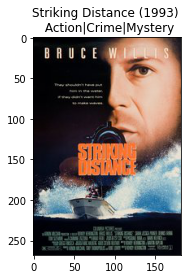

In [42]:
from IPython.display import clear_output

def GenrePerdictor(img):
    print("Original genres: ")
    img, genre = show_img("posters" + "\\" + img)
    for i in genre:
        print(i)
    
    dataset = []
    img = preprocess(img)
    dataset.append(img)
    
    pred = model.predict(np.array(dataset))

    perdicted = np.sort(largest_ele(pred[0], len(genre)))
    
    print("")
    print("Predicted genres: ")
    for i in perdicted:
        print(label_dict["idx2word"][i])

img = input("Enter image name: ")
clear_output(wait=True)

GenrePerdictor(img)